# Celebrity Face Generation

Here we'll try to generate fake images celebrity faces if they came from CelebA dataset using DC-GAN

In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
%matplotlib inline

## Load and Explore Data

In [1]:
# unzip the downloaded dataset
#!unzip processed-celeba-small.zip

data_dir = 'processed_celeba_small'

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    image_size = (image_size, image_size)
    transform = transforms.Compose([transforms.Resize(size=image_size),
                                    transforms.ToTensor()])
    ds = datasets.ImageFolder(root=data_dir,
                              transform=transform)
    
    dl = torch.utils.data.DataLoader(dataset=ds, 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     num_workers= 4)
    
    return dl


In [5]:
# Define function hyperparameters
batch_size = 128
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

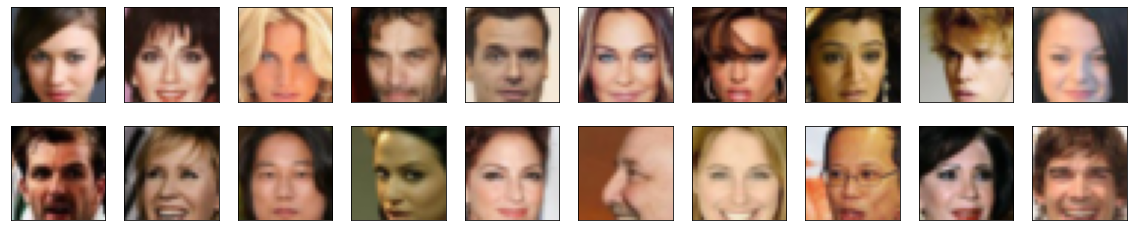

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

### Scale data

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x_min = feature_range[0]
    x_max = feature_range[1]    

    x = x * (x_max - x_min) - x_max
    
    return x


In [8]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

In [3]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # (3x32x32) --> (32x16x16)
        self.layer1_conv = nn.Conv2d(in_channels=3, out_channels=conv_dim, 
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.layer1_bn = nn.BatchNorm2d(conv_dim)
        self.layer1_leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        # (32x16x16) --> (128x8x8)
        self.layer2_conv = nn.Conv2d(in_channels=conv_dim, out_channels=conv_dim*4, 
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.layer2_bn = nn.BatchNorm2d(conv_dim*4)
        self.layer2_leaky_relu = nn.LeakyReLU(negative_slope=0.2)        
        # (128x8x8) --> (256x4x4)
        self.layer3_conv = nn.Conv2d(in_channels=conv_dim*4, out_channels=conv_dim*8, 
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.layer3_bn = nn.BatchNorm2d(conv_dim*8)
        self.layer3_leaky_relu = nn.LeakyReLU(negative_slope=0.2)        
        # (256x4x4) --> (512x2x2)
        self.layer4_conv = nn.Conv2d(in_channels=conv_dim*8, out_channels=conv_dim*16, 
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.layer4_bn = nn.BatchNorm2d(conv_dim*16)
        self.layer4_leaky_relu = nn.LeakyReLU(negative_slope=0.2)        
        # (512*2*2 = 2048) -> (1)
        self.layer5_fc = nn.Linear(in_features=conv_dim*16*2*2, out_features=1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # feedforward - convolutions
        x = self.layer1_leaky_relu(self.layer1_bn(self.layer1_conv(x)))
        x = self.layer2_leaky_relu(self.layer2_bn(self.layer2_conv(x)))
        x = self.layer3_leaky_relu(self.layer3_bn(self.layer3_conv(x)))
        x = self.layer4_leaky_relu(self.layer4_bn(self.layer4_conv(x)))
        # feedforward - logits
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        logits = self.layer5_fc(x)
        
        return logits

## Generator

In [4]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # Assume z_size = 100 and conv_dim = 32
        # (100) -> (2048) [2048 reshaped to (512x2x2)]
        self.layer1_fc = nn.Linear(in_features=z_size, out_features=conv_dim*64, bias=False)
        self.layer1_bn = nn.BatchNorm2d(int(conv_dim*64/4))
        self.layer1_leaky_relu = nn.LeakyReLU(negative_slope=0.2)        
        # (512x2x2) --> (256x4x4)
        self.layer2_deconv = nn.ConvTranspose2d(in_channels=int(conv_dim*64/4), out_channels=conv_dim*8, 
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.layer2_bn = nn.BatchNorm2d(conv_dim*8)
        self.layer2_leaky_relu = nn.LeakyReLU(negative_slope=0.2)        
         # (256x4x4) --> (128x8x8)
        self.layer3_deconv = nn.ConvTranspose2d(in_channels=conv_dim*8, out_channels=conv_dim*4, 
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.layer3_bn = nn.BatchNorm2d(conv_dim*4)
        self.layer3_leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        # (128x8x8) --> (64x16x16)
        self.layer4_deconv = nn.ConvTranspose2d(in_channels=conv_dim*4, out_channels=conv_dim*2, 
                               kernel_size=4, stride=2, padding=1, bias=False)
        self.layer4_bn = nn.BatchNorm2d(conv_dim*2)
        self.layer4_leaky_relu = nn.LeakyReLU(negative_slope=0.2)        
        # (64x16x16) --> (3x32x32)
        self.layer5_deconv = nn.ConvTranspose2d(in_channels=conv_dim*2, out_channels=3, 
                               kernel_size=4, stride=2, padding=1)

        self.tanh = nn.Tanh()
      

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # feedforward - logits
        x = self.layer1_fc(x)
        batch_size = x.shape[0]
        num_inputs = x.shape[1]
        
        x = x.view(batch_size, int(num_inputs/4), 2, 2)
        x = self.layer1_bn(x)
        x = self.layer1_leaky_relu(x)
        # feedforward - convolutions
        x = self.layer2_leaky_relu(self.layer2_bn(self.layer2_deconv(x)))
        x = self.layer3_leaky_relu(self.layer3_bn(self.layer3_deconv(x)))
        x = self.layer4_leaky_relu(self.layer4_bn(self.layer4_deconv(x)))
        x = self.layer5_deconv(x)
        # feedforward - tanh
        tanh = self.tanh(x)
        
        return tanh

## Initialize the weights of networks

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    if classname in ['Linear', 'Conv2d', 'ConvTranspose2d']:
        nn.init.normal_(tensor=m.weight, mean=0, std=0.02)   

## DC-GAN Network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. 

In [13]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [14]:
# Define model hyperparams
d_conv_dim = 32 
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (layer1_conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (layer1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1_leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer2_conv): Conv2d(32, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (layer2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2_leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer3_conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (layer3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3_leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer4_conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (layer4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4_leaky_relu): LeakyReLU(negative_slope=0.2)
  (lay

## Define Losses

In [16]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.shape[0]
    targets = torch.ones(batch_size)
    if train_on_gpu:
        targets = targets.cuda()
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(D_out.squeeze(), targets)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.shape[0]
    targets = torch.zeros(batch_size)
    if train_on_gpu:
        targets = targets.cuda()        
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(D_out.squeeze(), targets)
    return loss

## Train The Network

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [ ]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=[0.5, 0.999])
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=[0.5, 0.999])

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            # Reset discriminator's gradients
            d_optimizer.zero_grad()
            # Real images
            d_logits_real = D(real_images)
            d_real_loss = real_loss(d_logits_real)
            # Fake images
            z = np.random.uniform(-1, 1, size=(celeba_train_loader.batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            d_logits_fake = D(fake_images)
            d_fake_loss = fake_loss(d_logits_fake)
            # Total loss
            d_loss = d_real_loss + d_fake_loss
            # Backpropogate
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            # Reset generator's gradients            
            g_optimizer.zero_grad()            
            z = np.random.uniform(-1, 1, size=(celeba_train_loader.batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            g_logits_fake = D(fake_images)
            g_loss = real_loss(g_logits_fake) # Flip labels
            # Backpropogate
            g_loss.backward()
            g_optimizer.step()
                        
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [19]:
# set number of epochs 
n_epochs = 25

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   25] | d_loss: 1.6525 | g_loss: 1.8960
Epoch [    1/   25] | d_loss: 0.0803 | g_loss: 7.3687
Epoch [    1/   25] | d_loss: 0.1353 | g_loss: 4.7103
Epoch [    1/   25] | d_loss: 0.2489 | g_loss: 4.2138
Epoch [    1/   25] | d_loss: 0.4750 | g_loss: 2.4506
Epoch [    1/   25] | d_loss: 0.6643 | g_loss: 4.8237
Epoch [    1/   25] | d_loss: 0.7115 | g_loss: 3.9136
Epoch [    1/   25] | d_loss: 0.6220 | g_loss: 3.5880
Epoch [    1/   25] | d_loss: 0.7364 | g_loss: 2.4342
Epoch [    1/   25] | d_loss: 0.9393 | g_loss: 3.0697
Epoch [    1/   25] | d_loss: 0.7925 | g_loss: 3.0887
Epoch [    1/   25] | d_loss: 0.9051 | g_loss: 2.2048
Epoch [    1/   25] | d_loss: 0.5335 | g_loss: 3.3504
Epoch [    1/   25] | d_loss: 0.4187 | g_loss: 3.0541
Epoch [    1/   25] | d_loss: 0.6230 | g_loss: 3.1782
Epoch [    2/   25] | d_loss: 1.6932 | g_loss: 7.3080
Epoch [    2/   25] | d_loss: 0.4465 | g_loss: 2.8791
Epoch [    2/   25] | d_loss: 1.5532 | g_loss: 5.4439
Epoch [    2/   25] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

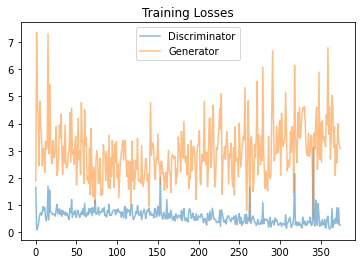

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Visualize Generator samples from training

View samples of images from the generator as it trains to see the progress

In [4]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [5]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Generator quality after epoch [1]...



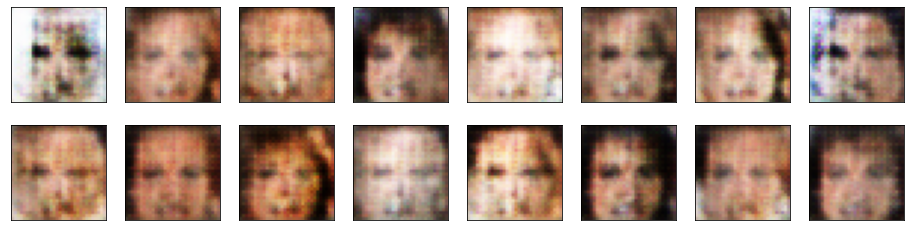

In [10]:
epoch = 1
print(f'Generator quality after epoch [{epoch}]...\n')
_ = view_samples(epoch-1, samples)

Generator quality after epoch [5]...



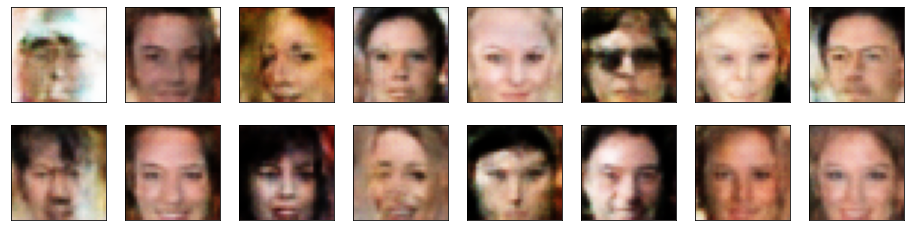

In [11]:
epoch = 5
print(f'Generator quality after epoch [{epoch}]...\n')
_ = view_samples(epoch-1, samples)

Generator quality after epoch [10]...



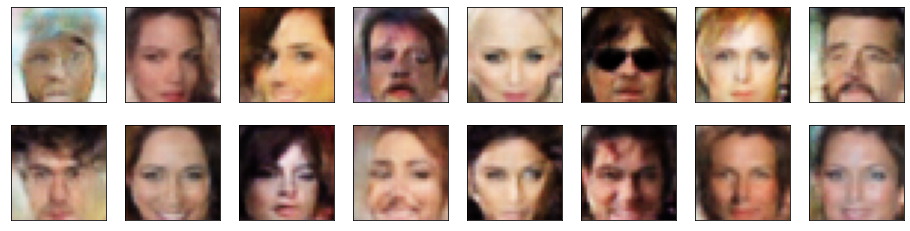

In [12]:
epoch = 10
print(f'Generator quality after epoch [{epoch}]...\n')
_ = view_samples(epoch-1, samples)

Generator quality after epoch [15]...



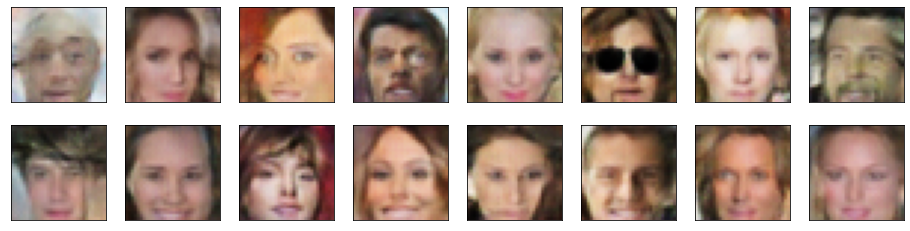

In [13]:
epoch = 15
print(f'Generator quality after epoch [{epoch}]...\n')
_ = view_samples(epoch-1, samples)

Generator quality after epoch [20]...



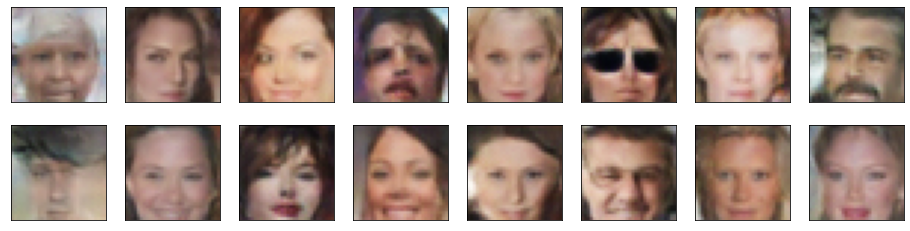

In [14]:
epoch = 20
print(f'Generator quality after epoch [{epoch}]...\n')
_ = view_samples(epoch-1, samples)

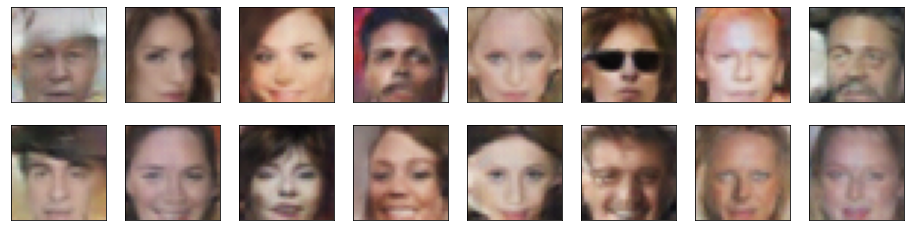

In [6]:
epoch = 25
print(f'Generator quality after epoch [{epoch}]...\n')
_ = view_samples(epoch-1, samples)

In [ ]:
##
# Function for diaplaying batch of generated images in a grid
##

def display_images(images, labels=None, n_cols=8, figsize=(12, 6)):
    n_images = images.shape[0]
    n_rows = math.ceil(n_images/n_cols)
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    for image_idx in range(n_images):
        # Grab an image tensor and reshape it to plt friendly shape
        image = images[image_idx]
        image = image.permute(1, 2, 0)
        ax = plt.subplot(n_rows, n_cols, image_idx+1)
        ax.imshow(image)
        if labels != None:
            ax.set_title(str(labels[image_idx].item()))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()